# PIEZO1 induced intracellular calcium dynamics in breast cancer cells
This notebook comprises the data analysis and modelling corresponding to Fig 2g-k and Supp Fig 2 our study:

So, C.L., Robitaille, M., Sadras, F. et al. Cellular geometry and epithelial-mesenchymal plasticity intersect with PIEZO1 in breast cancer cells. Commun Biol 7, 467 (2024). https://doi.org/10.1038/s42003-024-06163-z

Please see our paper for details of our computational methods and interpretation of results, and refer to the README for further details about this research project and how to cite this code.

The notebook is organised as follows:
* [Data import](#dataimport)
* [Time series visualisation](#vis)
* [Principal components analysis](#pca) (Fig 2g-j; Supp Fig 2a)
* [Caclium transient modelling](#model) (Fig 2k; Supp Fig 2b-c)

In [1]:
# Utils
import os
from pathlib import Path
from tqdm.notebook import tqdm
from itertools import product

# Data handling and qunatification
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.multivariate.manova import MANOVA
from scipy.optimize import curve_fit
from scipy.stats import ranksums
if not os.path.exists('intermediate'):
    os.makedirs('intermediate')

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
if not os.path.exists('figs'):
    os.makedirs('figs')

<a id='dataimport'></a>
## Data import

In [2]:
# Set data path
datapath = Path("data/200508_cytoo_mcf7_yoda_lean.csv")

# Import
df = pd.read_csv(datapath)
data = df[df.columns[:-2].values].groupby("label").agg('first').reset_index()
data = data.rename(columns={"Factor1":"Repeat","Factor2":"Concentration","Factor3":"Activator"})
data['t'] = np.zeros(data.shape[0])
data['t'] = data['t'].astype('object')
data['x'] = np.zeros(data.shape[0])
data['x'] = data['x'].astype('object')
for i,label in enumerate(data["label"]):
    t = df[df["label"]==label]["Elapsed.Time"].values
    x = df[df["label"]==label]["Normalised"].values
    data.at[i,'t'] = t
    data.at[i,'x'] = x

### Check sampling period
Sampling periods are not identical for all data, but very close. Unlikely to impact results given that the maximum difference is 50ms, which several orders of magnitude faster than the dynamics of the calcium transients.

**Therefore assume fixed sampling rate accross all data as the median of sampling rates $\approx$ 30.34s**

Median sampling period = 30.3385593220339 seconds


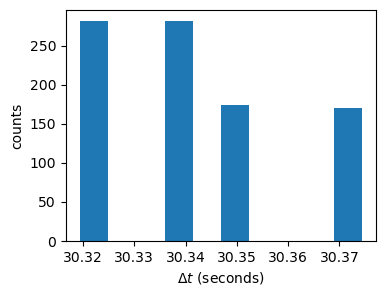

In [3]:
DT = []
for t in data['t']:
    dt = np.diff(t).mean()
    DT.append(dt)
DT = np.array(DT)

# Plot
fig,ax = plt.subplots(figsize=(4,3))
ax.hist(DT)
ax.set_xlabel(r'$\Delta t$ (seconds)')
ax.set_ylabel('counts')

dt = np.median(DT)

print(
    f'Median sampling period = {dt} seconds'
)

<a id='vis'></a>
## Time series visualisation

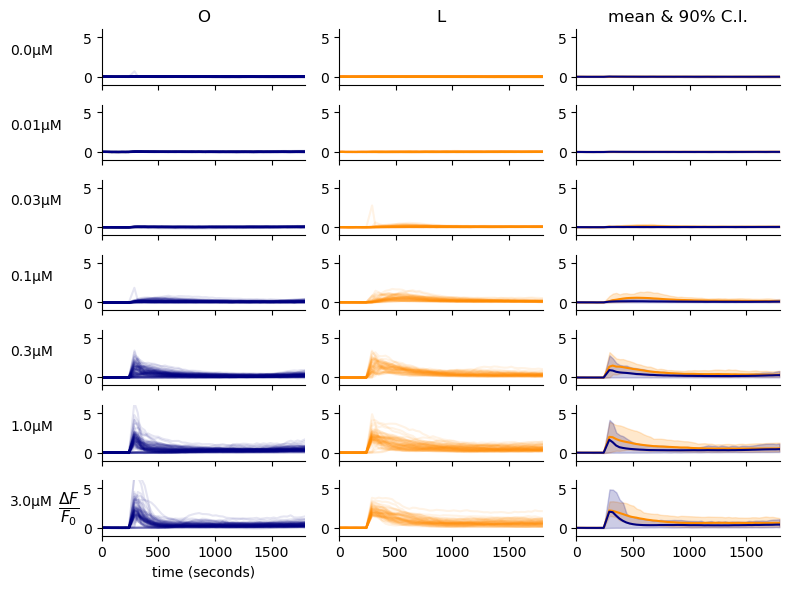

In [4]:
# Plot setup
fig,axs = plt.subplots(
    nrows=data["Concentration"].unique().size,
    ncols=3,
    figsize=(8,6),
    tight_layout=True,
)
color = {
    'L':'darkorange',
    'O':'navy',
}
axd = {
    'L':1,
    'O':0,
}

# Loop over cells and plot
X = np.zeros((data.shape[0],data.x[0].size))
for i in range(data.shape[0]):
    c = np.where(
        np.sort(data["Concentration"].unique())
        ==data["Concentration"][i]
    )[0][0]
    ax = axs[c,axd[data["Shape"][i]]]
    X[i,:] = data.x[i][:]
    ax.plot(data.t[i],data.x[i][:],c=color[data["Shape"][i]],alpha=0.1)

# Loop over axes to format
for ax in axs.flatten():
    ax.set_ylim(-1,6)
    ax.set_xlim(0,1800)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Add time axis label to bottom axes
ax = axs[-1,0]
ax.set_xlabel('time (seconds)')

# Remove x-tick labels for other axes
for ax in axs[:-1,:].flatten():
    ax.set_xticklabels('')

# Set column titles
axs[0,0].set_title('O')
axs[0,1].set_title('L')
axs[0,2].set_title(r'mean & 90% C.I.')

# Annotate concentrations
for ax,c in zip(axs[:,0],np.sort(data["Concentration"].unique())):
    ylabel = f'{c}\u03bcM'
    ax.text(
        -0.45,
        0.5,
        ylabel,
        ha='left',
        va='bottom',
        transform=ax.transAxes,
    )

# Add y label for df/f
axs[6,0].set_ylabel(
            r'$\frac{\Delta F}{F_0}$',
            fontsize=16,
            rotation=0,
            labelpad=10,
            va='center'
        )

# Plot mean curves
t = np.stack(data['t'].values).mean(axis=0)
for shape in  data["Shape"].unique():
    for c in np.sort(data["Concentration"].unique()):
        idx = (data['Shape']==shape) & (data["Concentration"]==c)
        x = X[idx,:].mean(axis=0)
        cdx = np.where(
            np.sort(data["Concentration"].unique())==c)[0][0]
        ax = axs[cdx,2]
        err_lower = np.percentile(X[idx,:],2.5,axis=0)
        err_upper = np.percentile(X[idx,:],97.5,axis=0)
        ax.fill_between(
            data.t[0],
            err_lower,
            err_upper,
            color=color[shape],
            alpha=0.2
        )
        ax.plot(t,x,c=color[shape])
        
# Save figure
fname = 'figs/timeseries.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

<a id='pca'></a>
## Principal Components Analysis of calcium transients

In [5]:
# Construct data array over full dataset
X = np.stack(data['x'].values,axis=0)

# Run PCA
pca = PCA(svd_solver='full')
pca.fit(X)

PCA(svd_solver='full')

The first three principal components explain $>95\%$ of the variance in the data.

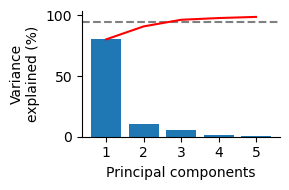

In [6]:
# Variance explained
n_components = 5

# Plot setup
fig,ax = plt.subplots(figsize=(3,2),tight_layout=True)

# Get data
x = np.arange(n_components)+1
y = pca.explained_variance_ratio_[:n_components]*100
yc = np.cumsum(y)

# 95% cutoff
ax.axhline(y=95,c='gray',ls='--')

# Plot
ax.bar(x,height=y)
ax.plot(x,yc,c='r')
ax.set_xlabel('Principal components')
ax.set_ylabel('Variance\nexplained (%)')
ax.set_xticks(np.arange(1,n_components+1))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

# Save figure
fname = 'figs/pca_varexplained.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

Principal components PC1 and PC2 appear to correspond to transients with slow and fast decay respectively. PC3 is a corresponds to a small peak, dip, then a gradual rise. PC3 may explain variance in rise times.

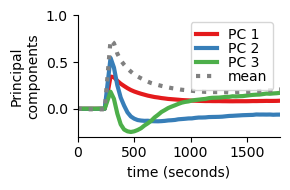

In [7]:
# Plot setup
fig,ax = plt.subplots(figsize=(3,2),tight_layout=True)
color_pc = cm.Set1(range(3))

# Get data
t = data['t'][0]

# Loop over components and plot
for i in range(3):
    ax.plot(
        t,
        pca.components_[i],
        linewidth=3,
        label=f'PC {i+1}',
        color=color_pc[i,:]
    )
    
# Plot data mean
ax.plot(
        t,
        pca.mean_,
        linewidth=3,
        label=f'mean',
        color='gray',
        ls=':'
    )

# Format plot
ax.set_ylabel('Principal\ncomponents')
ax.legend(
    loc='upper right',
    bbox_to_anchor=(1,1),
    handlelength=1.5,
    labelspacing=0,
)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_ylim(-0.3,1)
ax.set_xlim(t[0],t[-1])
ax.set_xlabel('time (seconds)')

# Save figure
fname = 'figs/pca_components.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

We use PCA, Linear Discriminant Analysis (LDA) and MANOVA testing to investigate differences between the dynamics for difference cell shapes at varying concentrations of the agonist.

* (first column) Scatter plots of the data projected onto PC1 and PC2 show the onset of separation of dynamics between the 'O' and 'L' shapes between agonist concentration 0.03uM and 0.1uM, forming distinct but overlapping clusters with increasing agonist concentration. Each datum corresponds to one cell. Colours as per the second columns of panels.
* (second column) Violin plots of LDA scores for each data based on fitting to only the first 3 principal components, revealing that the clusters for each cell shape are very unlikely to be drawn from the a single distribution (\*,\** and \*** are $p< 0.05$, $0.01$ and $0.001$ respectively; MANOVA test; $p$-values are shown after Bonferroni correction for 7 tests). Solid black lines show means.
* (third column) Weights for the LDA fits in the second column, showing that once the agonist concentration is $\geq0.03$ uM, the calcium dynamics between 'O' and 'L' are best separated along the dimension that is the difference between slow and fast decay.
* (fourth column) Reconstruction of the calcium dynamics correpsonding to the means of each group in PCA space from the first 3 principal components. As well as further demonstrating difference in the slow and fast decay, these panels show that rise times are slower for agonist concentrations $<0.3$ uM. The magnitude of the transient also appears to become more similar between cell shapes with increasing agonist concentration.

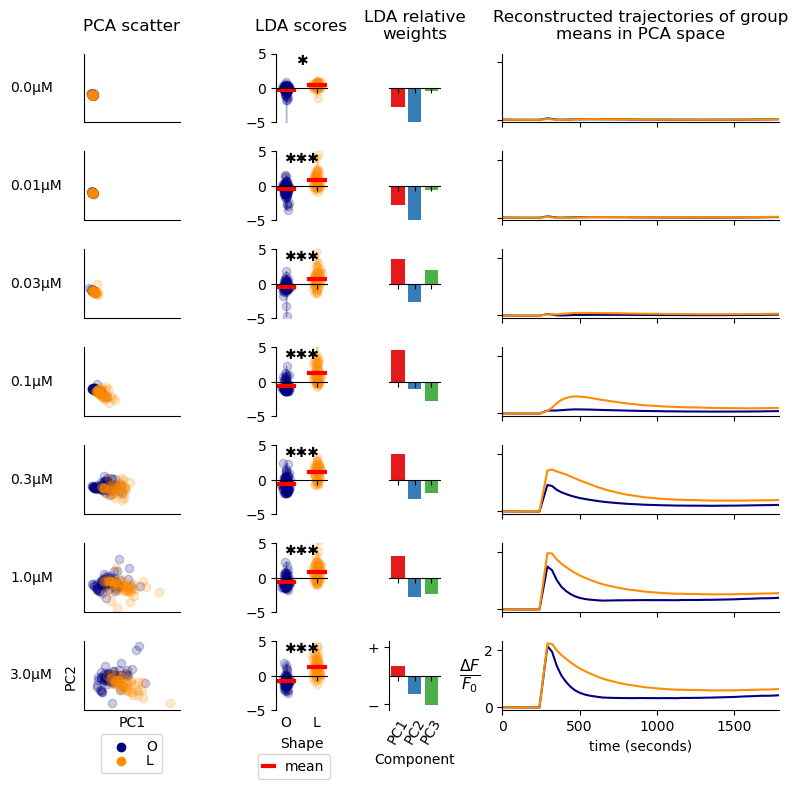

In [8]:
n_components = 3
pc_labels = [f'PC{n}' for n in np.arange(1,n_components+1)]

# Plot setup
fig = plt.figure(
    figsize=(8,8),
    tight_layout=True
)
gs = fig.add_gridspec(7,7)
axs = np.zeros((7,4),dtype='object')
for j in range(7):
    axs[j,0] = fig.add_subplot(gs[j,0:2])
    axs[j,1] = fig.add_subplot(gs[j,2:3])
    axs[j,2] = fig.add_subplot(gs[j,3:4])
    axs[j,3] = fig.add_subplot(gs[j,4:7])
fig.subplots_adjust(hspace =0, wspace=0)

# Loop over concentrations for MANOVA + Linear discriminant analysis
lda = LinearDiscriminantAnalysis(solver='svd')
for j,c in enumerate(np.sort(data['Concentration'].unique())):
    idx = data['Concentration']==c
    U = pca.transform(X)[idx,:n_components]
    labelencoder = LabelEncoder()
    labelencoder.classes_ = np.array(['O','L'])
    y = labelencoder.transform(data['Shape'][idx])
    df = pd.DataFrame(U,columns=pc_labels)
    df['y'] = y
    formula_string = ' + '.join(
        [f'PC{n}' for n in np.arange(1,n_components+1)]
    ) + ' ~ y'
    manova = MANOVA.from_formula(formula_string, data=df)
    stats = manova.mv_test()
    pval = stats.results['y']['stat'].loc["Wilks' lambda"]["Pr > F"]
    # Bonferroni correction
    pval = pval*7
    # LDA
    V = lda.fit_transform(U,y)
    
    # Plot LDA weights, scaled [-1,1]
    ax = axs[j,2]
    x = np.arange(n_components)+1
    h = lda.coef_.flatten()
    h = h/(np.abs(h).sum())
    ax.bar(
        x,
        height=h,
        color=color_pc
    )
    
    # Format LDA weight plots
    ax.set_xticks(np.arange(1,n_components+1))
    ax.set_ylim([-0.6,0.6])
    ax.set_yticks([])
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines['bottom'].set_position('zero')
    if j==6:
        # x-axis
        ax.set_xticklabels(pc_labels,rotation=60,va='top')
        ax.tick_params(axis='x', which='major', pad=25)
        ax.set_xlabel('Component',labelpad=5)
        # y-axis
        ax.set_yticks([-0.5,0.5])
        ax.set_yticklabels([f'$-$',f'$+$'])
    else:
        ax.set_xticklabels([])
        ax.spines.left.set_visible(False)


    # Plot LDA scores
    ax = axs[j,1]
    for i in range(2):
        x_scatter = np.random.randn(y[y==i].size)*0.05 + y[y==i]
        ax.scatter(
            x_scatter,
            V[y==i],
            c=color[labelencoder.classes_[i]],
            alpha=0.2
        )
        violin = ax.violinplot(
            V[y==i],
            positions=[i],
            showextrema=False,
            bw_method='silverman',
        )
        ymed = np.mean(V[y==i])
        if (j==6) & (i==1):
            ax.plot(
                [i-0.25,i+0.25],
                [ymed,ymed],
                lw=3,
                c='r',
                label='mean'
            )
        else:
            ax.plot(
                [i-0.25,i+0.25],
                [ymed,ymed],
                lw=3,
                c='r'
            )
        for pc in violin['bodies']:
            pc.set_facecolor(color[labelencoder.classes_[i]])
            pc.set_edgecolor(color[labelencoder.classes_[i]])
    
    # Format LDA scores plots
    ax.set_xticks([0,1])
    if j==6:
        ax.set_xticklabels(labelencoder.classes_,va='top')
        ax.tick_params(axis='x', which='major', pad=25)
        ax.set_xlabel('Shape',labelpad=5)
        ax.legend(
            handlelength=0.75,
            loc="lower left",
            bbox_to_anchor=[-0.5, -1.1]
        )
    else:
        ax.set_xticklabels([])
    ax.set_ylim([-5,5])
    ax.set_yticks([-5,0,5])
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines['bottom'].set_position('zero')
    
    # Plot significance
    pvals = np.array([0.001,0.01,0.05,1])
    asterisks = [
        ''.join(['\u2731' for jj in range(i)])
        for i
        in range(4)[::-1]
    ]
    pvalstr = asterisks[np.argmax(pval<pvals)]
    ax.text(0.5,5,pvalstr,ha='center',va='top')
    
    # Plot reconstructed trajectories
    ax = axs[j,3]
    for i in range(2):
        f = np.matmul(
            lda.means_[i],pca.components_[:n_components]
        ) + pca.mean_
        ax.plot(t,f,color=color[labelencoder.classes_[i]])
    ax.set_ylim([-0.1,2.3])
    ax.set_xlim([t.min(),t.max()])
    if j==6:
        ax.set_ylabel(
            r'$\frac{\Delta F}{F_0}$',
            fontsize=16,
            rotation=0,
            labelpad=10,
            va='center'
        )
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    if j==6:
        ax.set_xlabel('time (seconds)')
    else:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    
    # PCA scatter plot
    ax = axs[j,0]
    for i in range(2):
        ax.scatter(
            df['PC1'][y==i],
            df['PC2'][y==i],
            color=color[labelencoder.classes_[i]],
            alpha=0.2,
        )
        # Dummy plot for legend
        ax.scatter(
            -1000,
            -1000,
            color=color[labelencoder.classes_[i]],
            alpha=1,
            label=labelencoder.classes_[i],
        )
    
    # Format PCA scatter plot
    ax.set_xlim(-4,17)
    ax.set_ylim(-6,9)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if j==6:
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        pc.set_alpha(0.2)

# Set titles
axs[0,0].set_title('PCA scatter',pad=20,va='center')
axs[0,1].set_title('LDA scores',pad=20,va='center')
axs[0,2].set_title('LDA relative\nweights',pad=20,va='center')
axs[0,3].set_title(
    'Reconstructed trajectories of group\nmeans in PCA space',
    pad=20,
    va='center',
)

# Annotate concentration
for ax,c in zip(axs[:,0],np.sort(data["Concentration"].unique())):
    ylabel = f'{c}\u03bcM'
    ax.text(
        -20,
        np.array(axs[6,0].get_position())[0,1],
        ylabel,
        ha='left',
        va='bottom',
    )
    
# Add legend for PCA scatter
ax = axs[-1,0]
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5,-0.25),
    labelspacing=0,
)
    
# Save figure
fname = 'figs/pca_analysis.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

Same as above plotted with $3.0$ uM only.

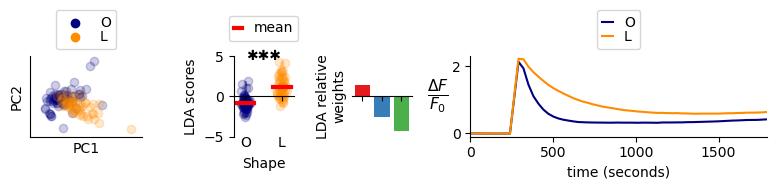

In [9]:
n_components = 3
pc_labels = [f'PC{n}' for n in np.arange(1,n_components+1)]

# Plot setup
fig = plt.figure(
    figsize=(8,2),
    tight_layout=True
)
gs = fig.add_gridspec(1,7)
axs = np.zeros((1,4),dtype='object')
for j in range(1):
    axs[j,0] = fig.add_subplot(gs[j,0:2])
    axs[j,1] = fig.add_subplot(gs[j,2:3])
    axs[j,2] = fig.add_subplot(gs[j,3:4])
    axs[j,3] = fig.add_subplot(gs[j,4:7])
fig.subplots_adjust(hspace =0, wspace=1.5)


# MANOVA + Linear discriminant analysis
lda = LinearDiscriminantAnalysis(solver='svd')
for j,c in enumerate([3.0]):
    idx = data['Concentration']==c
    U = pca.transform(X)[idx,:n_components]
    labelencoder = LabelEncoder()
    labelencoder.classes_ = np.array(['O','L'])
    y = labelencoder.transform(data['Shape'][idx])
    df = pd.DataFrame(U,columns=pc_labels)
    df['y'] = y
    formula_string = ' + '.join(
        [f'PC{n}' for n in np.arange(1,n_components+1)]
    ) + ' ~ y'
    manova = MANOVA.from_formula(formula_string, data=df)
    stats = manova.mv_test()
    pval = stats.results['y']['stat'].loc["Wilks' lambda"]["Pr > F"]
    
    # Bonferroni correction
    pval = pval*7
    
    # LDA
    V = lda.fit_transform(U,y)
    
    # Plot LDA weights, scaled [-1,1]
    ax = axs[j,2]
    x = np.arange(n_components)+1
    h = lda.coef_.flatten()
    h = h/(np.abs(h).sum())
    ax.bar(
        x,
        height=h,
        color=color_pc
    )
    
    # Format LDA weight plot
    ax.set_xticks(np.arange(1,n_components+1))
    ax.set_ylim([-0.6,0.6])
    ax.set_yticks([])
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines['bottom'].set_position('zero')
    if j==6:
        # x-axis
        ax.set_xticklabels(pc_labels,rotation=60,va='top')
        ax.tick_params(axis='x', which='major', pad=25)
        ax.set_xlabel('Component',labelpad=5)
        # y-axis
        ax.set_yticks([-0.5,0.5])
        ax.set_yticklabels([f'$-$',f'$+$'])
    else:
        ax.set_xticklabels([])
        ax.spines.left.set_visible(False)


    # Plot LDA scores
    ax = axs[j,1]
    for i in range(2):
        x_scatter = np.random.randn(y[y==i].size)*0.05 + y[y==i]
        ax.scatter(
            x_scatter,
            V[y==i],
            c=color[labelencoder.classes_[i]],
            alpha=0.2
        )
        violin = ax.violinplot(
            V[y==i],
            positions=[i],
            showextrema=False,
            bw_method='silverman',
        )
        ymed = np.mean(V[y==i])
        if (j==0) & (i==1):
            ax.plot(
                [i-0.25,i+0.25],
                [ymed,ymed],
                lw=3,
                c='r',
                label='mean'
            )
        else:
            ax.plot(
                [i-0.25,i+0.25],
                [ymed,ymed],
                lw=3,
                c='r'
            )
        for pc in violin['bodies']:
            pc.set_facecolor(color[labelencoder.classes_[i]])
            pc.set_edgecolor(color[labelencoder.classes_[i]])
    
    # Format LDA scores plot
    ax.set_xticks([0,1])
    if j==0:
        ax.set_xticklabels(labelencoder.classes_,va='top')
        ax.tick_params(axis='x', which='major', pad=25)
        ax.set_xlabel('Shape',labelpad=5)
        ax.legend(
            handlelength=0.6,
            loc="lower center",
            bbox_to_anchor=[0.5, 1.1]
        )
    else:
        ax.set_xticklabels([])
    ax.set_ylim([-5,5])
    ax.set_yticks([-5,0,5])
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines['bottom'].set_position('zero')
    
    # Plot significance
    pvals = np.array([0.001,0.01,0.05,1])
    asterisks = [
        ''.join(['\u2731'for jj in range(i)])
        for i
        in range(4)[::-1]
    ]
    pvalstr = asterisks[np.argmax(pval<pvals)]
    ax.text(0.5,5,pvalstr,ha='center',va='center')
    
    # Plot reconstructed trajectories
    ax = axs[j,3]
    for i in range(2):
        f = np.matmul(
            lda.means_[i],pca.components_[:n_components]
        ) + pca.mean_
        ax.plot(
            t,
            f,
            color=color[labelencoder.classes_[i]],
            label=labelencoder.classes_[i],
        )
    ax.set_ylim([-0.1,2.3])
    ax.set_xlim([t.min(),t.max()])
    if j==6:
        ax.set_ylabel(
            r'$\frac{\Delta F}{F_0}$',
            fontsize=16,
            rotation=0,
            labelpad=10,
            va='center'
        )
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    if j==0:
        ax.set_xlabel('time (seconds)')
    else:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    
    # PCA scatter plot
    ax = axs[j,0]
    for i in range(2):
        ax.scatter(
            df['PC1'][y==i],
            df['PC2'][y==i],
            color=color[labelencoder.classes_[i]],
            alpha=0.2,
        )
        # Dummy for legend
        ax.scatter(
            -1000,
            -1000,
            color=color[labelencoder.classes_[i]],
            alpha=1,
            label=labelencoder.classes_[i],
        )
    
    # Format PCA scatter plot
    ax.set_xlim(-4,17)
    ax.set_ylim(-6,9)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if j==0:
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        pc.set_alpha(0.2)

# Set axes labels
axs[0,1].set_ylabel('LDA scores')#,pad=20,va='center')
axs[0,2].set_ylabel('LDA relative\nweights')#,pad=20,va='center')
axs[0,3].set_ylabel(
            r'$\frac{\Delta F}{F_0}$',
            fontsize=16,
            rotation=0,
            labelpad=10,
            va='center'
        )

# Add legend for PCA scatter
ax = axs[0,0]
ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.5,1),
    labelspacing=0,
)

# Add legend for reconstructed trajectories
ax = axs[0,3]
ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.5,1),
    handlelength=0.75,
    labelspacing=0,
)
    
# Save figure
fname = 'figs/pca_analysis_conc3_00.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

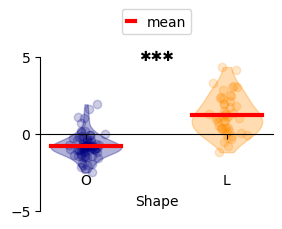

In [10]:
# Extract LDA scores data and save to CSV for reformated figure
n_components = 3
pc_labels = [f'PC{n}' for n in np.arange(1,n_components+1)]

# Plot setup
fig,ax = plt.subplots(figsize=(3,2))


# MANOVA + Linear discriminant analysis
lda = LinearDiscriminantAnalysis(solver='svd')
for j,c in enumerate([3.0]):
    idx = data['Concentration']==c
    U = pca.transform(X)[idx,:n_components]
    labelencoder = LabelEncoder()
    labelencoder.classes_ = np.array(['O','L'])
    y = labelencoder.transform(data['Shape'][idx])
    df = pd.DataFrame(U,columns=pc_labels)
    df['y'] = y
    formula_string = ' + '.join(
        [f'PC{n}' for n in np.arange(1,n_components+1)]
    ) + ' ~ y'
    manova = MANOVA.from_formula(formula_string, data=df)
    stats = manova.mv_test()
    pval = stats.results['y']['stat'].loc["Wilks' lambda"]["Pr > F"]
    
    # Bonferroni correction
    pval = pval*7
    
    # LDA
    V = lda.fit_transform(U,y)
    
    # Create table to save data
    LDAscores = pd.DataFrame(columns=['O','L'])
    # Plot LDA scores
    for i in range(2):
        save_data = V[y==i].reshape(-1,)
        save_data = np.pad(
            save_data,
            (0,75-save_data.size),
            mode='constant',
            constant_values=np.nan
        )
        LDAscores[labelencoder.classes_[i]] = save_data
        x_scatter = np.random.randn(y[y==i].size)*0.05 + y[y==i]
        ax.scatter(
            x_scatter,
            V[y==i],
            c=color[labelencoder.classes_[i]],
            alpha=0.2
        )
        violin = ax.violinplot(
            V[y==i],
            positions=[i],
            showextrema=False,
            bw_method='silverman',
        )
        ymed = np.mean(V[y==i])
        if (j==0) & (i==1):
            ax.plot(
                [i-0.25,i+0.25],
                [ymed,ymed],
                lw=3,
                c='r',
                label='mean'
            )
        else:
            ax.plot(
                [i-0.25,i+0.25],
                [ymed,ymed],
                lw=3,
                c='r'
            )
        for pc in violin['bodies']:
            pc.set_facecolor(color[labelencoder.classes_[i]])
            pc.set_edgecolor(color[labelencoder.classes_[i]])
    
    # Format LDA scores plot
    ax.set_xticks([0,1])
    if j==0:
        ax.set_xticklabels(labelencoder.classes_,va='top')
        ax.tick_params(axis='x', which='major', pad=25)
        ax.set_xlabel('Shape',labelpad=5)
        ax.legend(
            handlelength=0.6,
            loc="lower center",
            bbox_to_anchor=[0.5, 1.1]
        )
    else:
        ax.set_xticklabels([])
    ax.set_ylim([-5,5])
    ax.set_yticks([-5,0,5])
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines['bottom'].set_position('zero')
    
    # Plot significance
    pvals = np.array([0.001,0.01,0.05,1])
    asterisks = [
        ''.join(['\u2731'for jj in range(i)])
        for i
        in range(4)[::-1]
    ]
    pvalstr = asterisks[np.argmax(pval<pvals)]
    ax.text(0.5,5,pvalstr,ha='center',va='center')

    LDAscores.to_csv('LDAscores.csv')


<a id='model'></a>
## Nonlinear model
We model the calcium transient as the sum of an exponential rise and decay:
$$y(t) = -ae^{-\tau_{rise}t} + be^{-\tau_{decay}t} + c$$

Where:
* $y(t)$ is the $\frac{\Delta F}{F_0}$ time series;
* $t$ (`t`) is time
* $\tau_{rise}$ (`trise`) and $a$ (`a`) are scalar constants controlling the rate and magnitude of exponential rise respectively;
* $\tau_{decay}$ (`tdecay`) and $b$ (`b`) are scalar constants controlling the rate and magnitude of exponential decay respectively;
* $c$ (`c`) is a scalar constant corresponding to the steady state of the system.

We want a rise followed by a decay, therefore we constrain $\tau_{decay}<\tau_{rise}$. To achieve this we define:

$$\tau_{rise} \triangleq \tau_{decay} + \tau_{\Delta}$$

where $\tau_{\Delta}$ (`tdiff`) is positive ($\tau_{\Delta}\geq 0$; see Model fitting and bounds) and replaces $\tau_{rise}$ as a model parameter, then rewrite the model as:

$$y = -ae^{-(\tau_{decay}+\tau_{\Delta})t} + be^{-\tau_{decay}t} + c \text{ .}$$

We also want the fitted model to start at zero when the agonist is applied (i.e. conform to $y(t_0)=0$. This is achieved by constraining:

$$ a = b+c \text{ ,}$$

and rewrite the model with four parameters as:

$$y = -(b+c)e^{-(\tau_{decay}+\tau_{\Delta})t} + be^{-\tau_{decay}t} + c \text{ .}$$


### Model illustration
Below we plot a simple illustration of the model, with separate curves corresponding to the rise, decay and steady state terms.

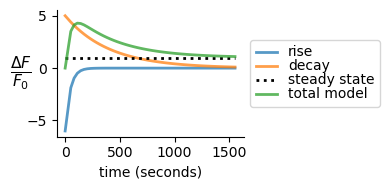

In [11]:
# Model schematic figure
n0=8
t = data['t'][0][n0:]
t = t-t[0]

tdiff = 1/50
tdecay = 1/400
b = 5
c = 1
a = b + c

decay = b*np.exp(-tdecay*t)
rise = -(b+c)*np.exp(-(tdecay+tdiff)*t)
constant = np.ones_like(t)*c
mdl = rise + decay + constant

fig,ax = plt.subplots(figsize=(4,2),tight_layout=True)


ax.plot(t,rise,lw=2,label='rise',alpha=0.75)
ax.plot(t,decay,lw=2,label='decay',alpha=0.75)
ax.plot(t,constant,lw=2,color='k',ls=':',label='steady state')
ax.plot(t,mdl,lw=2,label='total model',alpha=0.75)

hleg = ax.legend(
    loc='center left',
    bbox_to_anchor=(1,0.5),
    handlelength=1.5,
    labelspacing=0,
    )

ax.set_xlabel('time (seconds)')
ax.set_ylabel(
    r'$\frac{\Delta F}{F_0}$',
    rotation=0,
    fontsize=16,
    va='center'
)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

# Save figure
fname = 'figs/model_illustration.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

### Model fitting and bounds
We nonlinear least squares optimisation with a Trust Region Reflective algorithm as implemented in `scipy.optimize.curve_fit` to fit the model. This algorithm allows the specification of parameter bounds. Specifying parameter bounds keeps fitted models in a solution space which is interpretable. 

#### Bounds
In addition to the constraints written into the model, we specify the following bounds on the parameters:
* $\tau_{decay}\geq 0$
* $\tau_{\Delta} \geq 0$
* $b\geq 0$
* $0\leq c \leq \max y(t)$ for $t$ in the recorded range of the data.

It follows that $a\geq b$, which is also necessary to maintain the desired model behavior.

#### Initialisation
Nonlinear least squares fitting is an iterative process of making small adjustments to the parameters to improve the fit. This method requires an initial guess for all model parameters. The nature of the fitting algorithm means that it can get stuck in locally optimal solutions depending on the properties of the model, and hence the solution can be sensitive to the initial guess.

The constant $c$ can generally be well approximated by the median of the data, so we use this as the initial guess for this parameter. This is more effective than the mean because the data are skewed due to the asymmetrical nature of the rise/decay curve.

To address potential sensitivity to the initial values for other parameters, we run the model fit many times for a range of initialisations and keep the fit with the lowest error (sum of squared residuals $r^2$ or `err_r2`). Specifically we use a 3-dimensional grid search for the best nonlinear fit over following initial parameter guesses:
* $\tau_{decay}$ is initialised to 10 even spaced values on the range $[0.00067,0.067]$. $\tau_{decay}$ has units of seconds $^{-1}$ . The initial parameter range is more interpretable as the inverse with units of seconds, which is to say that $1/\tau_{decay}$ is initialised to 10 logarithmically space values on the range of $[15,1500]$ seconds.
* $\tau_{\Delta}$ is initialised to 6 logarithmically spaced values on the range $[10^{-6},10^{-1}]$.
* $b$ is initialised to 5 logarithmically spaced values on the range $[0.1,1000]$.


#### Other fitting considerations
We have increased the total number of allowable iterations for fitting to $10^6$ which consistently achieves convergence to within the tolerance threshold.

To ensure that the assumption what the model should start at zero is reasonable for the data, we shift each $\Delta F/F_0$ time series such that the the baseline is zero. We estimate the baseline fluorescence as the mean of the $\Delta F/F_0$ time series prior to the application of the agonist.

We do not attempt to fit the model where data clearly do not follow model assumptions. This includes:
* If the median of the time series is less than zero after baseline adjustment.
* If the distribution of the baseline data (i.e., prior to application of agonist) is not significantly different than the distribution after application of the agonist (one-sided Wilcoxon rank-sum test; significance level $\alpha = 0.005$).
* If the maximum value of the time series occurs in the latter half of the recording period. If the rise time is this slow then there is arguably not enough data to meaningfully fit the model.

In [12]:
# Define model
def model(t,tdiff,tdecay,b,c):
    return -(b+c)*np.exp(-(tdecay+tdiff)*t) + b*np.exp(-tdecay*t) + c

In [13]:
fname = 'intermediate/results.pkl'

if not os.path.exists(fname):
    # Fit model
    print(
        "Intermediate files do not exist. "
        "Fitting model and saving results...",
        flush=True,
    )

    # Create new columns in dataframe for model parameters
    for column_name in [
        'tdiff',
        'trise',
        'a',
        'tdecay',
        'b',
        'c',
        'err_r2',
        'err_rel',
    ]:
        data[column_name] = np.zeros((data.shape[0],))

    # Start fit at application of agonist
    n0 = 8

    # Points for initial value grid search
    TDIFF0s = np.logspace(-6,-1,6)
    TDECAY0s = 1/(1.5*np.logspace(1,3,10))
    B0s =  np.logspace(-1,3,5)

    # Loop over cells
    for i in tqdm(range(data.shape[0])):
        baseline = data['x'][i][:n0].mean()
        t = data['t'][i][n0:]
        t = t-t[0]
        y = data['x'][i][n0:]
        y = y - baseline

        # At least half of data above baseline
        bad_data0 = np.median(y)<0 
        # Distributions of data before and after agonist must be equal
        y0 = data['x'][i][:n0+1]
        y1 = data['x'][i][n0+1:]
        test_stat,pval = ranksums(y1,y0)
        pval = pval*2 # Correction for one-sided test
        bad_data1 = (test_stat<0) or (pval>0.005)
        # If the maximum value in the data occurs in the second half of
        # the time series
        bad_data2 = y.argmax()>(y.size/2)
        if bad_data0 or bad_data1 or bad_data2:
            # Store results in dataframe
            data.at[i,'tdiff'] = np.nan
            data.at[i,'trise'] = np.nan
            data.at[i,'a'] = np.nan
            data.at[i,'tdecay'] = np.nan
            data.at[i,'b'] = np.nan
            data.at[i,'c'] = np.nan
            data.at[i,'err_r2'] = np.nan
            data.at[i,'err_rel'] = np.nan
            # Skip to next cell
            continue

        # Bounds
        bounds = (
            # min bounds
            [
                0, # tdiff
                0, # tdecay
                0, # b
                0, # c
            ],
            # max bounds
            [
                1, # tdiff
                1, # td
                np.inf, # b
                y.max(), # c
            ],
        )
        # Grid search
        popt_best = np.zeros((4,))
        err_r2_best = 1e6
        for tdiff0,tdecay0,b0 in product(TDIFF0s,TDECAY0s,B0s):
            # Initial model parameter guess (manually tuned)
            p0 = (
                tdiff0, # tdiff
                tdecay0, # td
                b0, # b
                np.median(y), # c
            )

            # Curve fit
            popt,_ = curve_fit(
                f=model,
                xdata=t,
                ydata=y,
                p0=p0,
                bounds=bounds,
                method='trf',
                maxfev=int(1e6),
            )

            # Get model data
            yfit = model(
                t=t,
                tdiff=popt[0],
                tdecay=popt[1],
                b=popt[2],
                c=popt[3],
            )

            # Compute residuals
            err_r2 = np.mean((y-yfit)**2)
            err_rel = err_r2/(y.var())

            # Update best
            if err_r2<err_r2_best:
                err_r2_best = err_r2
                popt_best = popt

        # Get best
        popt = popt_best
        err_r2 = err_r2_best

        # Store results in dataframe
        data.at[i,'tdiff'] = popt[0]
        data.at[i,'trise'] = popt[0] + popt[1]
        data.at[i,'a'] = popt[2] + popt[3]
        data.at[i,'tdecay'] = popt[1]
        data.at[i,'b'] = popt[2]
        data.at[i,'c'] = popt[3]
        data.at[i,'err_r2'] = err_r2
        data.at[i,'err_rel'] = err_rel
        
    # Save output
    data.to_pickle(fname)
else:
    # Load the fitted model reuslts
    print(
         "Intermediate files exist. "
         "Loading data...",
         flush=True,
    )
    data = pd.read_pickle(fname)

Intermediate files exist. Loading data...


Plotting the data that did not meet the criteria for fitting.

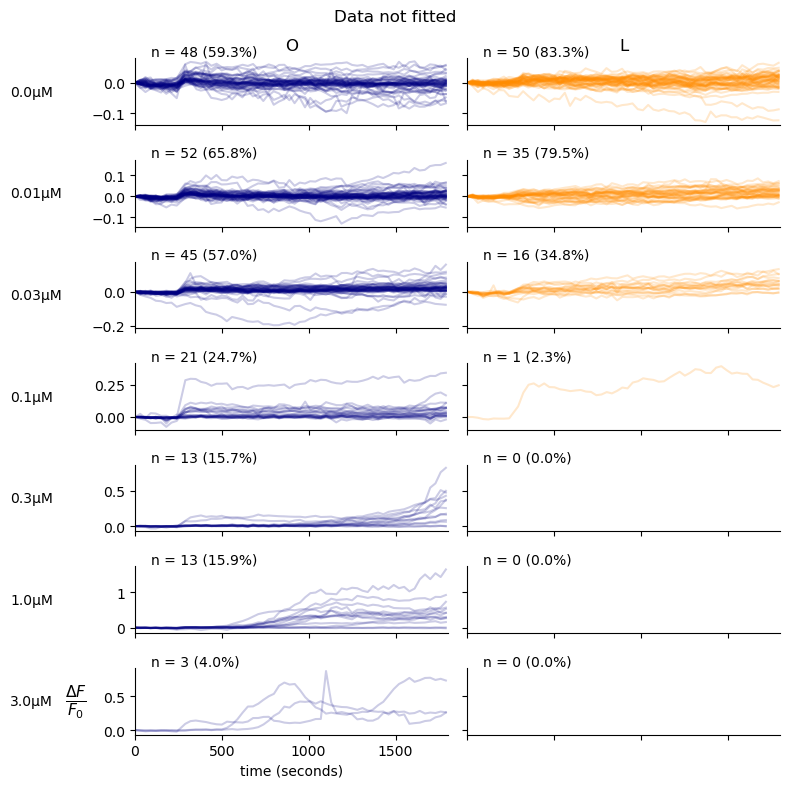

In [14]:
# Plot setup
fig,axs = plt.subplots(
    nrows=data["Concentration"].unique().size,
    ncols=2,
    figsize=(8,8),
    tight_layout=True,
    sharey='row',
    sharex='col'
)
fig.subplots_adjust(hspace =0, wspace=0)
for ax in axs.flatten():
    ax.count = 0
    ax.total = 0
color = {
    'L':'darkorange',
    'O':'navy',
}
axd = {
    'L':1,
    'O':0,
}

# Loop over cells
X = np.zeros((data.shape[0],data.x[0].size))
for i in range(data.shape[0]):
    c = np.where(
        np.sort(data["Concentration"].unique())
        ==data["Concentration"][i]
    )[0][0]
    if np.isnan(data['tdecay'][i]):
        ax = axs[c,axd[data["Shape"][i]]]
        X[i,:] = data.x[i][:]
        ax.plot(
            data.t[i],
            data.x[i][:],
            c=color[data["Shape"][i]],
            alpha=0.2,
        )
        ax.count += 1
        ax.total += 1
    else:
        ax = axs[c,axd[data["Shape"][i]]]
        ax.total += 1

# Format axes
for ax in axs.flatten():
    ax.set_xlim(0,1800)
    ax.set_xticks(np.arange(0,1600,500))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Plot n-vales and % of data
    ax.text(
        0.05,
        1,
        f'n = {ax.count:d} ({ax.count/ax.total*100:.1f}%)',
        va='bottom',
        transform=ax.transAxes
    )  
ax = axs[-1,0]
ax.set_xlabel('time (seconds)')
ax.set_xticklabels(np.arange(0,1600,500))
    
# Annotate concentration
for ax,c in zip(axs[:,0],np.sort(data["Concentration"].unique())):
    ylabel = f'{c}\u03bcM'
    ax.text(
        -0.4,
        0.5,
        ylabel,
        ha='left',
        va='center',
        transform=ax.transAxes,
    )

# Remove x tick labels
for ax in axs[:-1,-1].flatten():
    ax.set_xticklabels('')

# Set column titles
axs[0,0].set_title('O')
axs[0,1].set_title('L')

# Plot dff label
axs[6,0].set_ylabel(
    r'$\frac{\Delta F}{F_0}$',
    rotation=0,
    fontsize=16,
    va='center',
    labelpad=20
)

# Figure title
fig.suptitle('Data not fitted')

# Save figure
fname = 'figs/non-fits.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

Plotting the data that did meet the criteria for fitting.

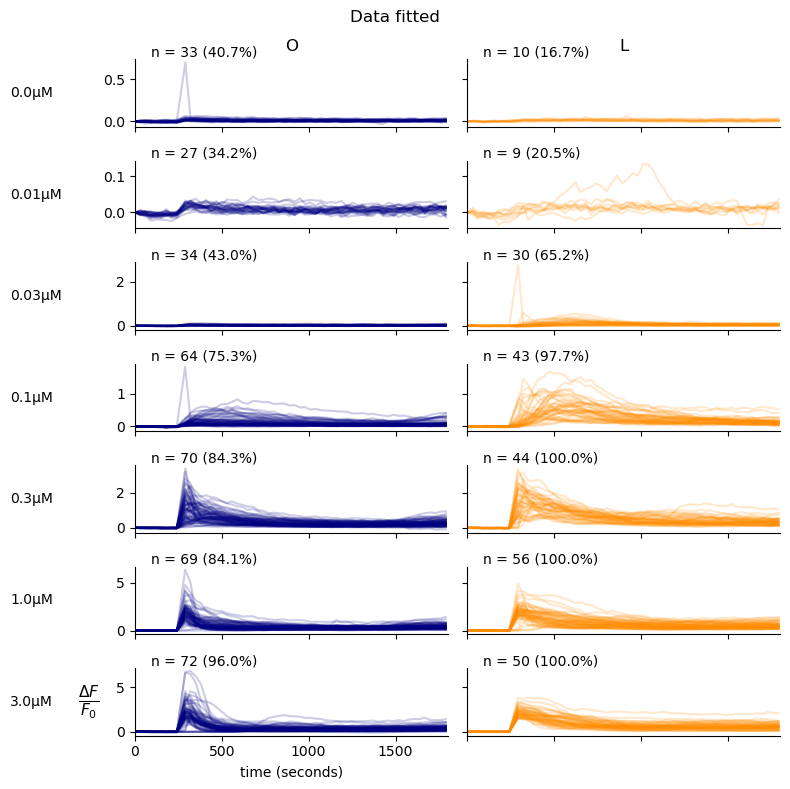

In [15]:
# Plot setup
fig,axs = plt.subplots(
    nrows=data["Concentration"].unique().size,
    ncols=2,
    figsize=(8,8),
    tight_layout=True,
    sharey='row',
    sharex='col'
)
fig.subplots_adjust(hspace =0, wspace=0)
for ax in axs.flatten():
    ax.count = 0
    ax.total = 0
color = {
    'L':'darkorange',
    'O':'navy',
}
axd = {
    'L':1,
    'O':0,
}

# Loop over cells
X = np.zeros((data.shape[0],data.x[0].size))
for i in range(data.shape[0]):
    c = np.where(
        np.sort(data["Concentration"].unique())
        ==data["Concentration"][i]
    )[0][0]
    if not (np.isnan(data['tdecay'][i])):
        ax = axs[c,axd[data["Shape"][i]]]
        X[i,:] = data.x[i][:]
        ax.plot(
            data.t[i],
            data.x[i][:],
            c=color[data["Shape"][i]],
            alpha=0.2
        )
        ax.count += 1
        ax.total += 1
    else:
        ax = axs[c,axd[data["Shape"][i]]]
        ax.total += 1

# Format axes
for ax in axs.flatten():
    ax.set_xlim(0,1800)
    ax.set_xticks(np.arange(0,1600,500))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Plot n-vales and % of data
    ax.text(
        0.05,
        1,
        f'n = {ax.count:d} ({ax.count/ax.total*100:.1f}%)',
        va='bottom',
        transform=ax.transAxes
    )  
ax = axs[-1,0]
ax.set_xlabel('time (seconds)')
ax.set_xticklabels(np.arange(0,1600,500))
    
# Annotate concentration
for ax,c in zip(axs[:,0],np.sort(data["Concentration"].unique())):
    ylabel = f'{c}\u03bcM'
    ax.text(
        -0.4,
        0.5,
        ylabel,
        ha='left',
        va='center',
        transform=ax.transAxes,
    )

# Remove xtick labels
for ax in axs[:-1,-1].flatten():
    ax.set_xticklabels('')

# Set column titles
axs[0,0].set_title('O')
axs[0,1].set_title('L')

# Plot dff label
axs[6,0].set_ylabel(
    r'$\frac{\Delta F}{F_0}$',
    rotation=0,
    fontsize=16,
    va='center',
    labelpad=20
)

# Plot figure title
fig.suptitle('Data fitted')

# Save figure
fname = 'figs/fitted_data.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

### Decay times are longer for shape 'L' than shape 'O'
We plot the model error and decay times for all cells which met the criteria for model fitting and test for differences in the distributions of shape 'O' and 'L' cells at each agonist concentration using a ranksum test. Resulting $p$-values are Bonferroni corrected by a factor of 7.

Decay time for shape 'L' is significantly longer once concentration reaches $0.3$ uM.

Note that we have cropped the y-axis because of several very large outliers.

0.00016589361027282584
0.016714949273492395
2.755889712611826e-08
2.5944913023376312e-05
0.7933783789133209
0.2639765797617232
0.13245938715800334


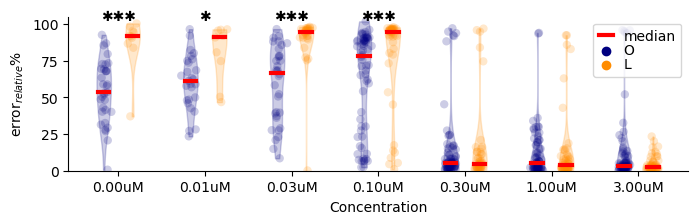

In [16]:
fig,ax = plt.subplots(figsize=(8,2))

concentrations = np.sort(data["Concentration"].unique())

xbar = [[i+0.5,i+1.5] for i in range(0,concentrations.shape[0]*3,3)]

for k,c in enumerate(concentrations):

    Y = [0,0]
    for i,shape in enumerate(['O','L']):
        # Get data
        idx = (
            (data["Concentration"]==c)
            & (data["Shape"]==shape)
        )
        y = (data['err_rel'][idx])
        y = y[~np.isnan(y)]
        y = y*100
        

        # Scatter plot
        x_scatter = np.random.randn(y.size)*0.1 + xbar[k][i]
        ax.scatter(
            x_scatter,
            y,
            c=color[shape],
            edgecolor='none',
            alpha=0.2
        )

        # Violin plot
        ymed = np.median(y)
        violin = ax.violinplot(
            y,
            positions=[xbar[k][i]],
            showextrema=False,
            bw_method='silverman',
        )
        # Median plot and scatter dummy plot
        if (k==6) and (i==1):
            ax.plot(
                [xbar[k][i]-0.2,xbar[k][i]+0.2],
                [ymed,ymed],
                lw=3,
                c='r',
                label='median'
            )
            xlim = ax.get_xlim()
            for s in ['O','L']:
                ax.scatter(-1000,50,color=color[s],label=s)
            ax.set_xlim(xlim)
        else:
            ax.plot(
                [xbar[k][i]-0.2,xbar[k][i]+0.2],
                [ymed,ymed],
                lw=3,
                c='r'
            )
        for pc in violin['bodies']:
            pc.set_facecolor(color[shape])
            pc.set_edgecolor(color[shape])
            pc.set_alpha(0.2)
        Y[i] = y
    
    # Significance testing
    _,pval = ranksums(Y[0],Y[1])
    print(pval)
    pvals = np.array([0.001,0.01,0.05,np.inf])
    asterisks = [
        ''.join(['\u2731' for jj in range(i)])
        for i
        in range(4)[::-1]
    ]
    pvalstr = asterisks[np.argmax(pval<pvals)]
    ax.text(np.mean(xbar[k]),110,pvalstr,ha='center',va='top')

# Format plot
ax.set_xticks(np.array(xbar).mean(axis=1))
ax.set_xticklabels(
    [f'{c:.2f}uM' for c in concentrations]
)
ax.set_xlabel('Concentration')
ax.set_ylim([0,105])
ax.set_ylabel(r'error$_{relative}$%')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

# Add legend
ax.legend(
    handlelength=1,
    loc="upper right",
    labelspacing=0
#     bbox_to_anchor=[1.4, -0.1]
)

# Save figure
fname = 'figs/fir_error.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

0.014684188210078053
0.12917629538497274
0.09672000578234584
0.464154866124721
0.003425338100958935
0.00014982496169467643
1.7588506300586556e-08


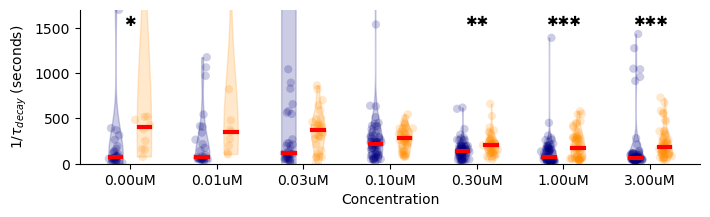

In [17]:
fig,ax = plt.subplots(figsize=(8,2))

concentrations = np.sort(data["Concentration"].unique())

# Set x positions
xbar = [[i+0.5,i+1.5] for i in range(0,concentrations.shape[0]*3,3)]

for k,c in enumerate(concentrations):

    Y = [0,0]
    for i,shape in enumerate(['O','L']):
        # Get data
        idx = (
            (data["Concentration"]==c)
            & (data["Shape"]==shape)
        )
        y = 1/(data['tdecay'][idx])
        y = y[~np.isnan(y)]
        

        # Scatter plot
        x_scatter = np.random.randn(y.size)*0.1 + xbar[k][i]
        ax.scatter(
            x_scatter,
            y,
            c=color[shape],
            edgecolor='none',
            alpha=0.2
        )

        # Violin plot
        ymed = np.median(y)
        violin = ax.violinplot(
            y,
            positions=[xbar[k][i]],
            showextrema=False,
            bw_method='silverman',
        )
        for pc in violin['bodies']:
            pc.set_facecolor(color[shape])
            pc.set_edgecolor(color[shape])
            pc.set_alpha(0.2)
        
        # Median plot
        if False:#(k==0) and (i==0):
            ax.plot(
                [xbar[k][i]-0.2,xbar[k][i]+0.2],
                [ymed,ymed],
                lw=3,
                c='r',
                label='median'
            )
        else:
            ax.plot(
                [xbar[k][i]-0.2,xbar[k][i]+0.2],
                [ymed,ymed],
                lw=3,
                c='r'
            )
        Y[i] = y
    
    # Significance testing
    _,pval = ranksums(Y[0],Y[1])
    #Bonferroni correction
    pval = pval*7
    print(pval)
    pvals = np.array([0.001,0.01,0.05,np.inf])
    asterisks = [''.join(['\u2731' for jj in range(i)]) for i in range(4)[::-1]]
    pvalstr = asterisks[np.argmax(pval<pvals)]
    ax.text(np.mean(xbar[k]),1650,pvalstr,ha='center',va='top')

# Format plot
ax.set_xticks(np.array(xbar).mean(axis=1))
ax.set_xticklabels(
    [f'{c:.2f}uM' for c in concentrations]
)
ax.set_xlabel('Concentration')
ax.set_ylim([0,1700])
ax.set_ylabel(r'$1/\tau_{decay}$ (seconds)')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

# ax.legend(
#     handlelength=1,
#     loc="center left",
# #     bbox_to_anchor=[1.4, -0.1]
# )

# Save figure
fname = 'figs/fit_decay.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

Re-plotted for concentrations $\geq0.30$ uM

307.4711304069735
394.69255093464767
275.31700842785085
488.7993492825526
996.291976788612
573.3821069186087


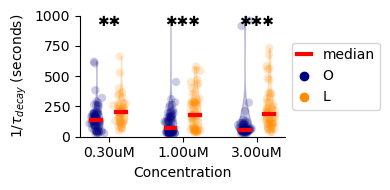

In [18]:
# Plot setup
fig,ax = plt.subplots(
    figsize=(4,2),
    tight_layout=True,
    facecolor='w'
)

# Select only concentrations >= 0.30um
concentrations = np.sort(data["Concentration"].unique())[4:]

# Set x positions
xbar = [[i+0.5,i+1.5] for i in range(0,concentrations.shape[0]*3,3)]

for k,c in enumerate(concentrations):

    Y = [0,0]
    for i,shape in enumerate(['O','L']):
        # Get data
        idx = (
            (data["Concentration"]==c)
            & (data["Shape"]==shape)
        )
        y = 1/(data['tdecay'][idx])
        y = y[~np.isnan(y)]
        
        # Scatter plot
        x_scatter = np.random.randn(y.size)*0.1 + xbar[k][i]
        ax.scatter(
            x_scatter,
            y,
            c=color[shape],
            edgecolor='none',
            alpha=0.2
        )
        print(np.percentile(y,95))

        # Violin plot
        ymed = np.median(y)
        violin = ax.violinplot(
            y,
            positions=[xbar[k][i]],
            showextrema=False,
            bw_method='silverman',
        )
        for pc in violin['bodies']:
            pc.set_facecolor(color[shape])
            pc.set_edgecolor(color[shape])
            pc.set_alpha(0.2)
        # Median plot and scatter dummy plot
        if (k==2) and (i==1):
            ax.plot(
                [xbar[k][i]-0.2,xbar[k][i]+0.2],
                [ymed,ymed],
                lw=3,
                c='r',
                label='median'
            )
            xlim = ax.get_xlim()
            for s in ['O','L']:
                ax.scatter(-1000,50,color=color[s],label=s)
            ax.set_xlim(xlim)
        else:
            ax.plot(
                [xbar[k][i]-0.2,xbar[k][i]+0.2],
                [ymed,ymed],
                lw=3,
                c='r'
            )
        Y[i] = y
    
    # Significance testing
    _,pval = ranksums(Y[0],Y[1])
    #Bonferroni correction
    pval = pval*7
#     print(pval)
    pvals = np.array([0.001,0.01,0.05,np.inf])
    asterisks = [
        ''.join(['\u2731' for jj in range(i)])
        for i
        in range(4)[::-1]
    ]
    pvalstr = asterisks[np.argmax(pval<pvals)]
    ax.text(np.mean(xbar[k]),1000,pvalstr,ha='center',va='top')

# Format plot
ax.set_xticks(np.array(xbar).mean(axis=1))
ax.set_xticklabels(
    [f'{c:.2f}uM' for c in concentrations]
)
ax.set_xlabel('Concentration')
ax.set_ylim([0,1000])
ax.set_ylabel(r'$1/\tau_{decay}$ (seconds)')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

# Add legend
ax.legend(
    handlelength=1,
    loc="center left",
    bbox_to_anchor=[1, 0.5]
)

# Save figure
fname = 'figs/fit_decay_conc0_30-3.pdf'
fig.savefig(fname,format='pdf', pad_inches=0)

Plot of example fit.

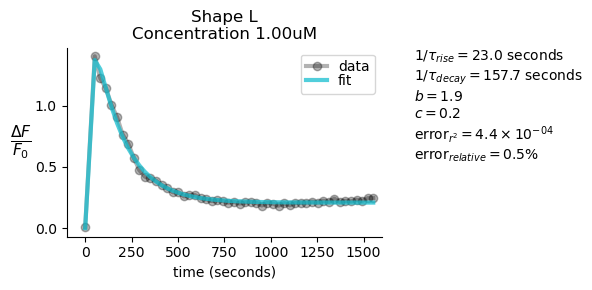

In [19]:
# Plot setup
fig,ax = plt.subplots(
    figsize=(6,3),
    tight_layout=False,
    facecolor='w'
)

# Prep data
i=381
baseline = data['x'][i][:n0].mean()
t = data['t'][i][n0:]
t = t-t[0]
y = data['x'][i][n0:]
y = y - baseline

# Plot data
ax.plot(t,y,label='data',color='k',alpha=0.3,lw=3,marker='o')
yfit = model(
        t=t,
        tdiff=data['tdiff'][i],
        tdecay=data['tdecay'][i],
        b=data['b'][i],
        c=data['c'][i],
    )

# Plot model fit
plt.plot(t,yfit,label='fit',color='tab:cyan',alpha=0.75,lw=3)

# Annotate model fit params
err_str =  f'{data["err_r2"][i]:.1e}'
err_str = '$' + err_str.replace('e',r'\times 10^{') +'}$\n'
param_str = (
    r'$1/\tau_{rise}=$'
    + f'{1/data["trise"][i]:.1f} seconds\n'
    + r'$1/\tau_{decay}=$'
    + f'{1/data["tdecay"][i]:.1f} seconds\n'
    + r'$b = $'
    + f'{data["b"][i]:.1f}\n'
    + r'$c = $'
    + f'{data["c"][i]:.1f}\n'
    + r'error$_{r^2} = $'
    + err_str
    + r'error$_{relative} = $'
    + f'{data["err_rel"][i]*100:.1f}%\n'
)
ax.text(
    1.1,
    1,
    param_str,
    va='top',
    transform=ax.transAxes
)

# Add legend
hleg = ax.legend(
    loc='upper right',
    handlelength=1.5,
    labelspacing=0,
    )

# Format plot
ax.set_xlim(-100,1600)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('time (seconds)')
ax.set_ylabel(
    r'$\frac{\Delta F}{F_0}$',
    rotation=0,
    fontsize=16,
    va='center',
    labelpad=10,
)
title_str = (
    'Shape '
    + data["Shape"][i]
    + f'\nConcentration {data["Concentration"][i]:.2f}uM'
)
ax.set_title(title_str)
ax.set_position([0.15,0.2,0.4,0.6])


# Save figure
fname = (
    'figs/model_fit_shape'
    + data['Shape'][i]
    + f'_conc{data["Concentration"][i]:.2f}'.replace('.','_')
    + f'_num{i:03d}.pdf'
)
fig.savefig(fname,format='pdf', pad_inches=0)

Re-plotting example fits of transients with median error

O
L


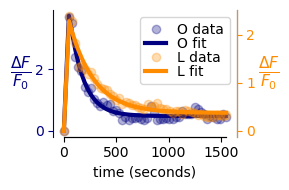

In [20]:
# Plot setup
fig,ax1 = plt.subplots(
    figsize=(3,2),
    tight_layout=True,
    facecolor='w'
    )
axs= [ax1, ax1.twinx()]

# Intialising variable which is used later for scaling time axis
tmax = 0

# Loop over cell shapes
for ax,shape in zip(axs,['O','L']):
    # Get cell which has median error
    idx = (
        (data["Concentration"]==3.0)
        & (data["Shape"]==shape)
    )
    y = (data['err_rel'][idx])
    y = y[~np.isnan(y)]
    i = y.sort_values().index[len(y)//2]
    
    # Prep data
    baseline = data['x'][i][:n0].mean()
    t = data['t'][i][n0:]
    t = t-t[0]
    tmax = max(tmax,max(t))
    y = data['x'][i][n0:]
    y = y - baseline

    # Plot data
    ax.plot(
        t,
        y,
#         label='L data',
        color=color[shape],
        alpha=0.3,
        lw=0,
        marker='o',
        ls=''
    )
    
    # Plot model fil
    yfit = model(
            t=t,
            tdiff=data['tdiff'][i],
            tdecay=data['tdecay'][i],
            b=data['b'][i],
            c=data['c'][i],
        )
    ax.plot(
        t,
        yfit,
#         label='L fit',
        color=color[shape],
        alpha=1,
        lw=3,
        ls='-'
    )
    err_str =  f'{data["err_r2"][i]:.1e}'
    err_str = '$' + err_str.replace('e',r'\times 10^{') +'}$\n'
    param_str = (
        r'$1/\tau_{rise}=$'
        + f'{1/data["trise"][i]:.1f} seconds\n'
        + r'$1/\tau_{decay}=$'
        + f'{1/data["tdecay"][i]:.1f} seconds\n'
        + r'$b = $'
        + f'{data["b"][i]:.1f}\n'
        + r'$c = $'
        + f'{data["c"][i]:.1f}\n'
        + r'error$_{r^2} = $'
        + err_str
        + r'error$_{relative} = $'
        + f'{data["err_rel"][i]*100:.1f}%\n'
    )
# Annotate model fit params
#     ax.text(
#         1.1,
#         1,
#         param_str,
#         va='top',
#         transform=ax.transAxes
#     )

# Format plot
    ax.set_xlim(-100,tmax+100)
#     ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(0,tmax)
#     ax.yaxis.set_ticks_position('left')
#     ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('time (seconds)')
    ax.set_ylabel(
        r'$\frac{\Delta F}{F_0}$',
        rotation=0,
        fontsize=16,
        va='center',
        labelpad=10,
        color=color[shape]
    )
    ax.tick_params(
        axis='y',
        color=color[shape],
        labelcolor=color[shape]
    )
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    title_str = (
        'Shape '
        + data["Shape"][i]
        + f'\nConcentration {data["Concentration"][i]:.2f}uM'
    )
#     ax.set_title(title_str)
#     ax.set_position([0.15,0.2,0.4,0.6])
for ax,shape in zip(axs,['O','L']):
    if shape == 'O':
        print(shape)
        ax.spines['left'].set_color(color[shape])
    else:
        print(shape)
        ax.spines['right'].set_color(color[shape])
        ax.spines['left'].set_visible(False)

# Add legend
ax = axs[1]
for shape in ['O','L']:
    # Dummy plot
    ax.plot(
        [-1000,-9999],
        [0.5,0.5],
        label=shape+' data',
        color=color[shape],
        alpha=0.3,
        lw=0,
        marker='o',
        ls=''
    )
    # Dummy plot
    ax.plot(
        [-1000,-9999],
        [0.5,0.5],
        label=shape+' fit',
        color=color[shape],
        alpha=1,
        lw=3,
        ls='-'
    )
hleg = ax.legend(
        loc='upper right',
        handlelength=1.5,
        labelspacing=0,
        )        

# Save figure
fname = (
    'figs/model_fit_overlay.pdf'
)
fig.savefig(fname,format='pdf', pad_inches=0)

Plots all fits individually for qualitative inspection.

  0%|          | 0/908 [00:00<?, ?it/s]

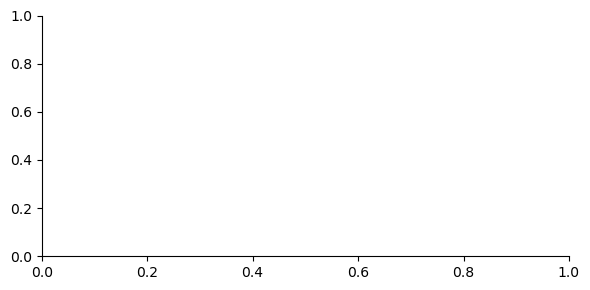

In [21]:
fig,ax = plt.subplots(
    figsize=(6,3),
    tight_layout=False,
    facecolor='w'
)

for i in tqdm(range(data.shape[0])):
    baseline = data['x'][i][:n0].mean()
    t = data['t'][i][n0:]
    t = t-t[0]
    y = data['x'][i][n0:]
    y = y - baseline
    
    ax.plot(t,y,label='data',color='k',alpha=0.3,lw=3,marker='o')
    yfit = model(
            t=t,
            tdiff=data['tdiff'][i],
            tdecay=data['tdecay'][i],
            b=data['b'][i],
            c=data['c'][i],
        )

    plt.plot(t,yfit,label='fit',color='tab:cyan',alpha=0.75,lw=3)
    err_str =  f'{data["err_r2"][i]:.1e}'
    err_str = '$' + err_str.replace('e',r'\times 10^{') +'}$\n'
    param_str = (
        r'$1/\tau_{rise}=$'
        + f'{1/data["trise"][i]:.1f} seconds\n'
        + r'$1/\tau_{decay}=$'
        + f'{1/data["tdecay"][i]:.1f} seconds\n'
        + r'$b = $'
        + f'{data["b"][i]:.1f}\n'
        + r'$c = $'
        + f'{data["c"][i]:.1f}\n'
        + r'error$_{r^2} = $'
        + err_str
        + r'error$_{relative} = $'
        + f'{data["err_rel"][i]*100:.1f}%\n'
    )
    ax.text(
        1.1,
        1,
        param_str,
        va='top',
        transform=ax.transAxes
    )


    hleg = ax.legend(
        loc='upper right',
        handlelength=1.5,
        labelspacing=0,
        )

    ax.set_xlim(-100,1600)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xlabel('time (seconds)')
    ax.set_ylabel(
        r'$\frac{\Delta F}{F_0}$',
        rotation=0,
        fontsize=16,
        va='center',
        labelpad=10,
    )
    
    title_str = (
        'Shape '
        + data["Shape"][i]
        + f'\nConcentration {data["Concentration"][i]:.2f}uM'
    )
    ax.set_title(title_str)
    
    ax.set_position([0.15,0.2,0.4,0.6])
    
    
    # Save figure
    fpath = Path(
        'figs/model_fits/'
        + data['Shape'][i]
        + f'/{data["Concentration"][i]:.2f}'.replace('.','_')
        + f'/{i:03d}.pdf'
    )
    if not os.path.exists(fpath):
        os.makedirs(fpath,exist_ok=True)
    fig.savefig(fpath/'{i:03d}.pdf',format='pdf', pad_inches=0)
    ax.clear()